In [1]:
import micrograph as mg
import dncnn
import util

import numpy as np
import torch

from matplotlib import pyplot as plt
import matplotlib
font = {'family' : 'DejaVu Sans',
        'size'   : 14}
matplotlib.rc('font', **font)

np.random.seed(77)

# Convergence of PnP Methods for PBM Denoising

In [2]:
def getXDiffRMSE(hist):
    xHist = np.stack(hist['x'])
    xDiff = (xHist - xHist[-1]).reshape(xHist.shape[0], -1)
    xDiffRMSE = np.sqrt(np.mean(xDiff ** 2, axis=1))
    return xDiffRMSE[1:]

In [3]:
# Measurement
lamb = 20
n = 200
etaRange = [2, 8]
dynamicRange = etaRange[1] - etaRange[0]
etaGt = util.readImageToEta('data/sponge/val/0.jpg', minEta=etaRange[0], maxEta=etaRange[1])
yTr, MTr = mg.poiPoiTrSampling(etaGt, lamb, n, retM = True)
yConv = np.sum(yTr, axis=0)
MConv = np.sum(MTr, axis=0)

In [4]:
# Parameters
rho = 2.5
maxIter = 50
tol = 5e-4
gdStepSize = 0.1
etaInit = yConv / MConv

# For DnCNN prior
device = torch.device('cpu')
model = dncnn.DnCNN(17)
dncnn.loadCheckpoint('model/std25.ckpt', model)

ADMMApp:   0%|          | 0/50 [00:00<?, ?it/s]

MSE = 0.14117862422558944
RMSE = 0.37573744054271385
PSNR = 24.065335553520203
SNR = 22.160316690630147
SSIM = 0.6942795663912835


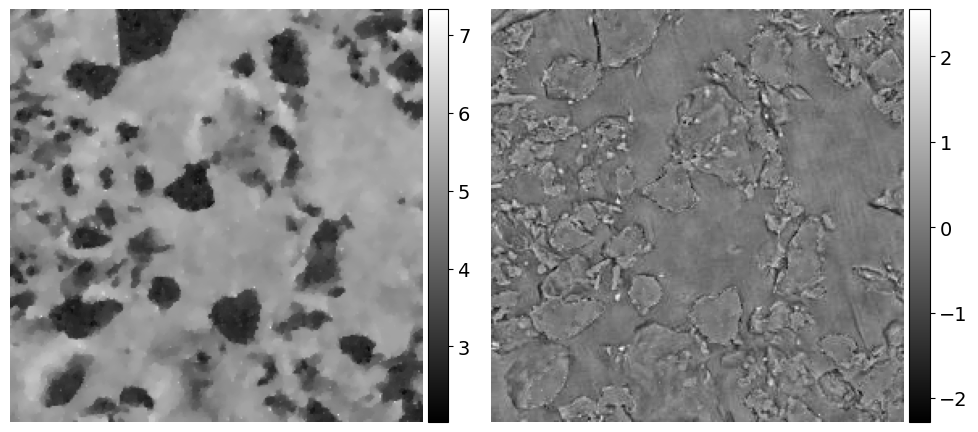

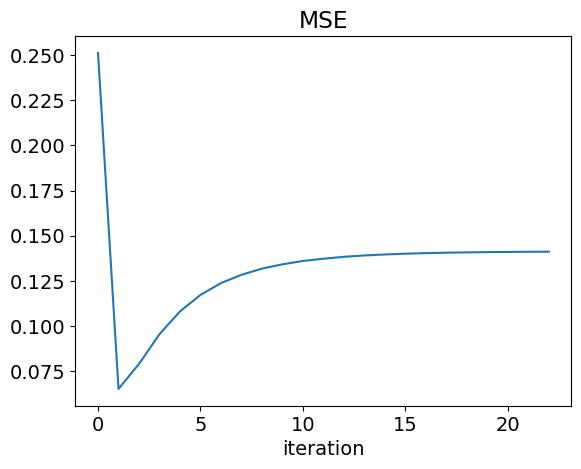

In [5]:
# Gaussian-TV ADMM
fidProx = mg.GaussApproxFidProx(yTr, lamb)
priorProx = mg.TVPriorProx(0.72)
app = mg.ADMMApp(fidProx, priorProx, rho, etaInit, maxIter,
                tol=tol, xGt=etaGt, fullLogging=True)
etaRecon = app.run()

util.showErrorMetrics(etaRecon, etaGt, dynamicRange)
error = etaRecon - etaGt
util.imshow([etaRecon, error])
util.summarizeSolve(app.hist)
gaussTvDiff = getXDiffRMSE(app.hist)

ADMMApp:   0%|          | 0/50 [00:00<?, ?it/s]

MSE = 0.13704133380376907
RMSE = 0.37019094235781763
PSNR = 24.194509238629717
SNR = 22.884522500409865
SSIM = 0.8331035190926253


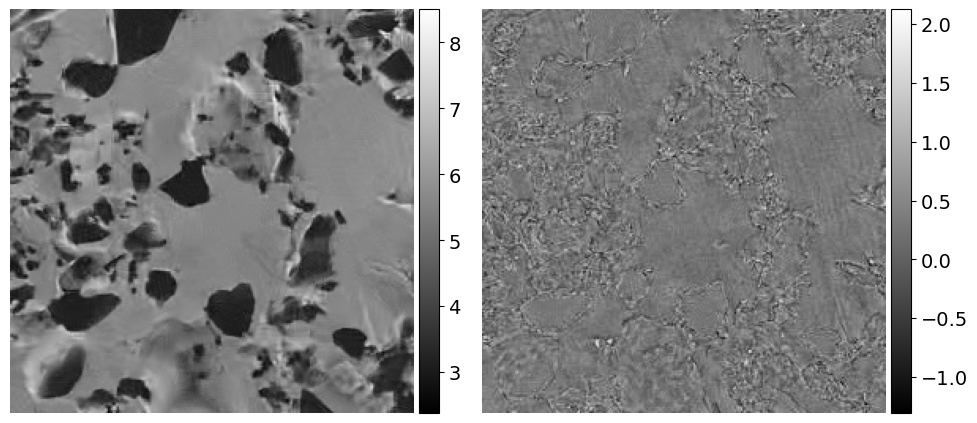

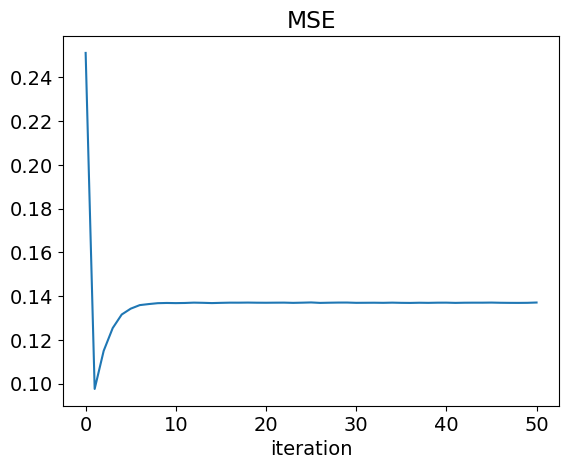

In [6]:
# QM-BM3D ADMM
fidProx = mg.QMFidProx(yTr)
priorProx = mg.Bm3dPriorProx(0.72)
app = mg.ADMMApp(fidProx, priorProx, rho, etaInit, maxIter,
                tol=tol, xGt=etaGt, fullLogging=True)
etaRecon = app.run()

util.showErrorMetrics(etaRecon, etaGt, dynamicRange)
error = etaRecon - etaGt
util.imshow([etaRecon, error])
util.summarizeSolve(app.hist)
qmBm3dDiff = getXDiffRMSE(app.hist)

ADMMApp:   0%|          | 0/50 [00:00<?, ?it/s]

MSE = 0.13244312002301603
RMSE = 0.3639273554200289
PSNR = 24.342730976934565
SNR = 23.035506379907204
SSIM = 0.8423170351269245


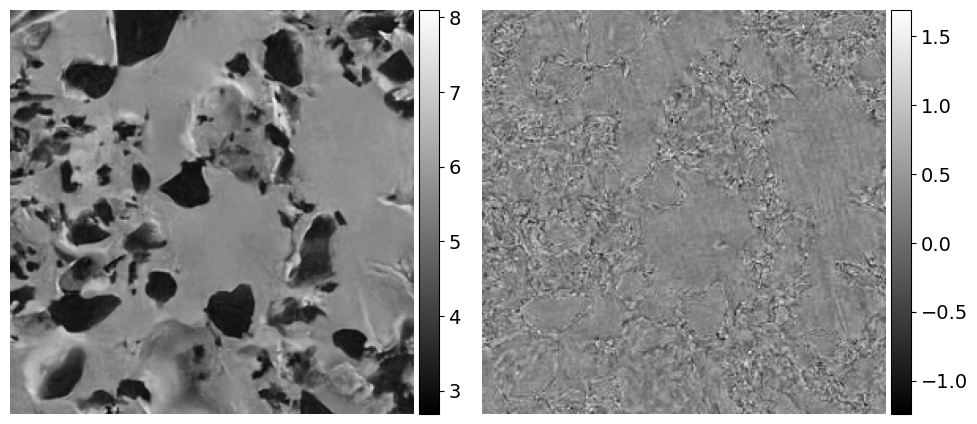

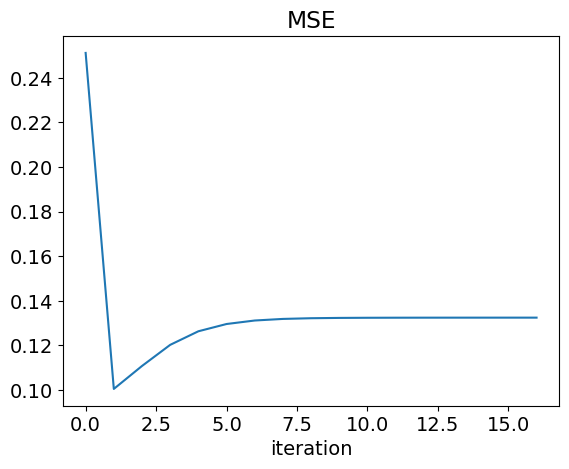

In [7]:
# QM-DnCNN ADMM
fidProx = mg.QMFidProx(yTr)
priorProx = mg.DnCNNPriorProx(model, device=device, mu=0.75, imRange=etaRange, denRange=[0, 1])
app = mg.ADMMApp(fidProx, priorProx, rho, etaInit, maxIter,
                tol=tol, xGt=etaGt, fullLogging=True)
etaRecon = app.run()

util.showErrorMetrics(etaRecon, etaGt, dynamicRange)
error = etaRecon - etaGt
util.imshow([etaRecon, error])
util.summarizeSolve(app.hist)
qmDnCNNDiff = getXDiffRMSE(app.hist)

ADMMApp:   0%|          | 0/50 [00:00<?, ?it/s]

MSE = 0.10937981008101613
RMSE = 0.3307261859620676
PSNR = 25.173653358047172
SNR = 23.802554399599565
SSIM = 0.8410929922115803


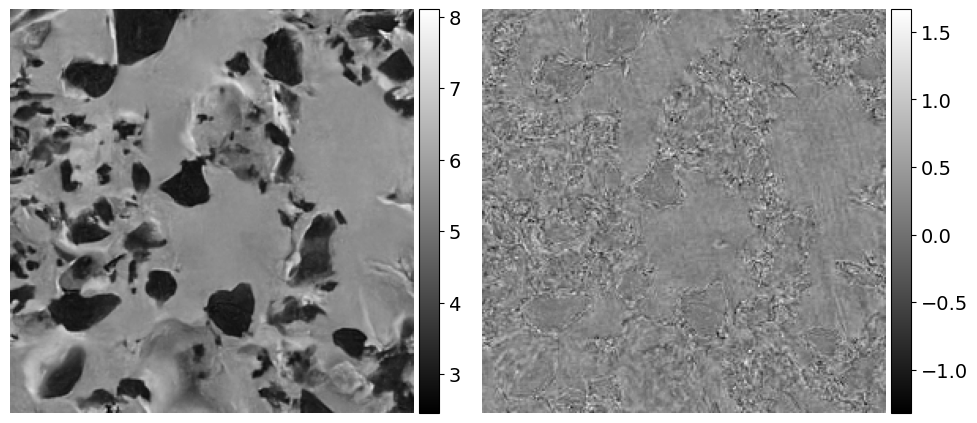

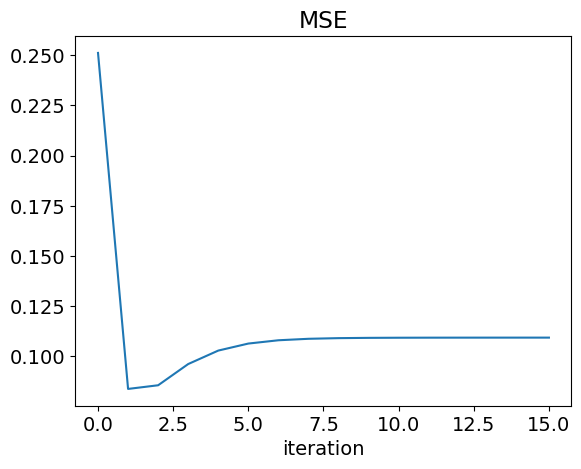

In [8]:
# LQM-DnCNN ADMM
fidProx = mg.LQMApproxFidProx(yTr)
priorProx = mg.DnCNNPriorProx(model, device=device, mu=0.75, imRange=etaRange, denRange=[0, 1])
app = mg.ADMMApp(fidProx, priorProx, rho, etaInit, maxIter,
                tol=tol, xGt=etaGt, fullLogging=True)
etaRecon = app.run()

util.showErrorMetrics(etaRecon, etaGt, dynamicRange)
error = etaRecon - etaGt
util.imshow([etaRecon, error])
util.summarizeSolve(app.hist)
lqmDnCNNDiff = getXDiffRMSE(app.hist)

PGMApp:   0%|          | 0/50 [00:00<?, ?it/s]

MSE = 0.06323020670198123
RMSE = 0.25145617252710506
PSNR = 27.553778992263588
SNR = 25.742834947881718
SSIM = 0.8042257040527785


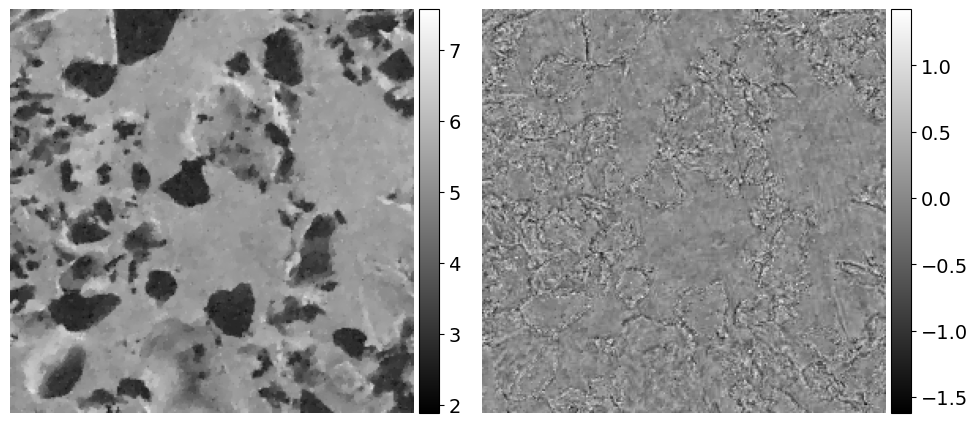

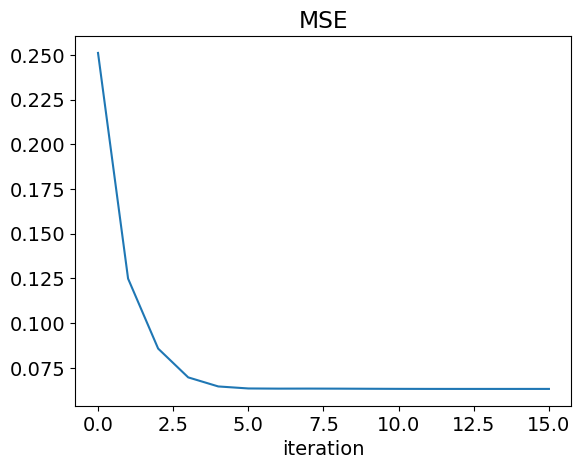

In [9]:
# TRML-TV FISTA
fidGrad = mg.TRApproxFidGrad(yTr, lamb)
priorProx = mg.TVPriorProx(0.24)
app = mg.PGMApp(fidGrad, priorProx, gdStepSize, etaInit, maxIter, fista=True,
                tol=tol, xGt=etaGt, fullLogging=True)
etaRecon = app.run()

util.showErrorMetrics(etaRecon, etaGt, dynamicRange)
error = etaRecon - etaGt
util.imshow([etaRecon, error])
util.summarizeSolve(app.hist)
trmlTvDiff = getXDiffRMSE(app.hist)

PGMApp:   0%|          | 0/50 [00:00<?, ?it/s]

MSE = 0.08795477553836839
RMSE = 0.2965717038733945
PSNR = 26.120430761476964
SNR = 24.27137784938966
SSIM = 0.7603396444586218


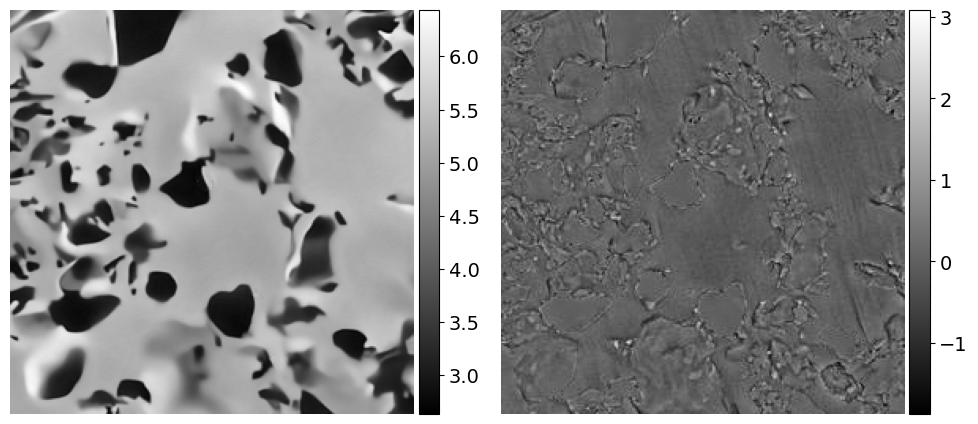

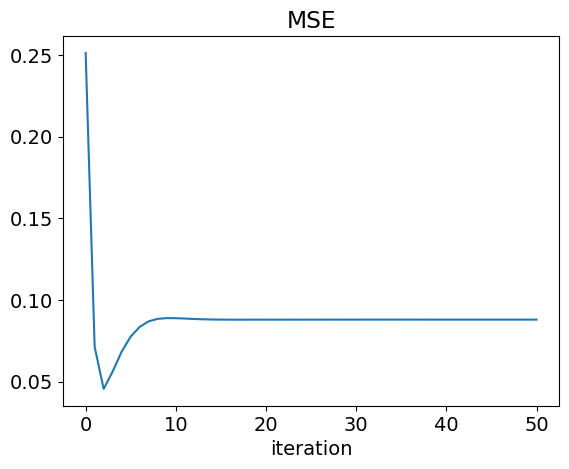

In [10]:
# TRML-DnCNN FISTA
fidGrad = mg.TRApproxFidGrad(yTr, lamb)
priorProx = mg.DnCNNPriorProx(model, device=device, mu=1.5, imRange=etaRange, denRange=[0, 1])
app = mg.PGMApp(fidGrad, priorProx, gdStepSize, etaInit, maxIter, fista=True,
                tol=tol, xGt=etaGt, fullLogging=True)
etaRecon = app.run()

util.showErrorMetrics(etaRecon, etaGt, dynamicRange)
error = etaRecon - etaGt
util.imshow([etaRecon, error])
util.summarizeSolve(app.hist)
trmlDnCNNDiff = getXDiffRMSE(app.hist)

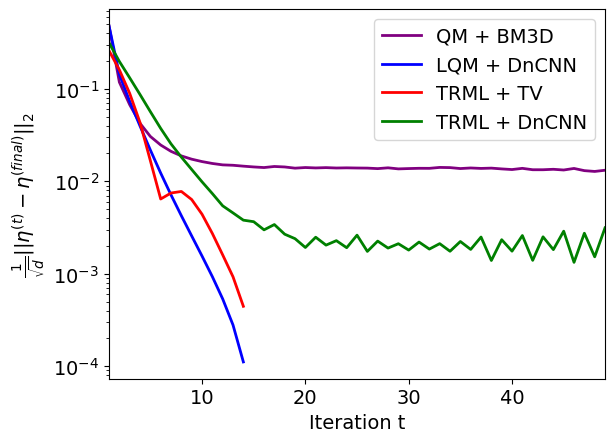

In [16]:
# plt.plot(np.arange(1, len(gaussTvDiff) + 1), gaussTvDiff, label='Gaussian + TV')
plt.plot(np.arange(1, len(qmBm3dDiff)), qmBm3dDiff[:-1], label='QM + BM3D', lw=2, c='purple')
# plt.plot(np.arange(1, len(qmDnCNNDiff) + 1), qmDnCNNDiff, label='QM + DnCNN')
plt.plot(np.arange(1, len(lqmDnCNNDiff)), lqmDnCNNDiff[:-1], label='LQM + DnCNN', lw=2, c='b')
plt.plot(np.arange(1, len(trmlTvDiff)), trmlTvDiff[:-1], label='TRML + TV', lw=2, c='r')
plt.plot(np.arange(1, len(trmlDnCNNDiff)), trmlDnCNNDiff[:-1], label='TRML + DnCNN', lw=2, c='g')
plt.xlabel('Iteration t')
plt.ylabel(r'$\frac{1}{\sqrt{d}}||\eta^{(t)} - \eta^{(final)}||_2$')
plt.xlim([1, 49])
plt.legend()
plt.yscale('log')
plt.show()